# CNN Training

Target of this code is to train a CNN network to extract the needle position of an analog needle device.

### Preparing the training
* First all libraries are loaded
    * It is assumed, that they are installed during the Python setup
* matplotlib is set to print the output inline in the jupyter notebook

In [22]:
########### Basic Parameters for Running: ################################
    
TFliteNamingAndVersion = "ana0900s1_long"   # Used for tflite Filename
Training_Percentage = 0.2              # 0.0 = Use all Images for Training
Epoch_Anz = 100

##########################################################################



import os
import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import numpy as np
from sklearn.utils import shuffle
from tensorflow.python import keras
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import History 
import math
from PIL import Image 

loss_ges = np.array([])
val_loss_ges = np.array([])

%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

### Load training data
* The data is expected in the "Input_dir"
* Picture size must be 32x32 with 3 color channels (RGB)
* The filename contains the informations needed for training in the first 3 digits::
* Typical filename: 
    * x.y-zzzz.jpg 
    * e.g. "4.6_Lfd-1406_zeiger3_2019-06-02T050011"

|Place holder | Meaning                     | Usage        |
|------------- |-----------------------------|--------------|
| **x.y**          | readout value               | **to be learned** |
| zzzz        | additional information              | not needed   |

* The images are stored in the x_data[]
* The expected output for each image in the corresponding y_data[]
    * The periodic nature is reflected in a **sin/cos coding**, which allows to restore the angle/counter value with an arctan later on.

* The last step is a shuffle (from sklearn.utils) as the filenames are on order due to the encoding of the expected analog readout in the filename 

In [2]:
Input_dir='data_resize_all'

files = glob.glob(Input_dir + '/*.*')
x_data = []
y_data = []

for aktfile in files:
    test_image = Image.open(aktfile)
    test_image = np.array(test_image, dtype="float32")
    test_image = np.reshape(test_image, (32,32,3))
    base = os.path.basename(aktfile)
    target_number = (float(base[0:3])) / 10
    target_sin = math.sin(target_number * math.pi * 2)
    target_cos = math.cos(target_number * math.pi * 2)

    x_data.append(test_image)
    zw = np.array([target_sin, target_cos])
    y_data.append(zw)

x_data = np.array(x_data)
y_data = np.array(y_data)
print(x_data.shape)
print(y_data.shape)

x_data, y_data = shuffle(x_data, y_data)

if (Training_Percentage > 0):
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Training_Percentage)
else:
    X_train = x_data
    y_train = y_data

(5127, 32, 32, 3)
(5127, 2)


### Define the model

The layout of the network ist a typcial CNN network with alternating **Conv2D** and **MaxPool2D** layers. Finished after **flattening** with additional **Dense** layer.

#### Important
* Shape of the input layer: (32, 32, 3)
* Shape of the output layer: (2) - sin and cos

In [3]:
model = Sequential()
model.add(BatchNormalization(input_shape=(32,32,3)))
model.add(Conv2D(32, (5, 5), input_shape=(32,32,3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(4,4)))
model.add(Conv2D(32, (5, 5), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(4,4)))
model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(64,activation="relu"))
model.add(Dense(2))
model.summary()

model.compile(loss=keras.losses.mean_squared_error, optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95), metrics = ["accuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 32, 32, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 32)          25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 32)          9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 32)          0

# Training
The input pictures are randomly scattered for brightness and pixel shift variations. These is implemented with a ImageDataGenerator.


The training is splitted into two steps:
1. Variation of the brightness only
2. Variation of brightness and Pixel Shift

### Step 1: Brigthness scattering only

In [4]:
Batch_Size = 8
Epoch_Anz = 100
Shift_Range = 0
Brightness_Range = 0.3

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], height_shift_range=[-Shift_Range,Shift_Range],brightness_range=[1-Brightness_Range,1+Brightness_Range])

if (Training_Percentage > 0):
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)
    history = model.fit_generator(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    history = model.fit_generator(train_iterator, epochs = Epoch_Anz)



Epoch 1/100


C:\Users\Muell\anaconda3\envs\ct-make-py38-tf24\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


641/641 [==============================] - 12s 18ms/step - loss: 0.3244 - accuracy: 0.7076 - val_loss: 0.0209 - val_accuracy: 0.9688
Epoch 2/100
641/641 [==============================] - 10s 15ms/step - loss: 0.0212 - accuracy: 0.9660 - val_loss: 0.1031 - val_accuracy: 0.9376
Epoch 3/100
641/641 [==============================] - 10s 16ms/step - loss: 0.0117 - accuracy: 0.9758 - val_loss: 0.0056 - val_accuracy: 0.9776
Epoch 4/100
641/641 [==============================] - 13s 20ms/step - loss: 0.0069 - accuracy: 0.9778 - val_loss: 0.0061 - val_accuracy: 0.9844
Epoch 5/100
641/641 [==============================] - 12s 18ms/step - loss: 0.0055 - accuracy: 0.9820 - val_loss: 0.0050 - val_accuracy: 0.9854
Epoch 6/100
641/641 [==============================] - 12s 19ms/step - loss: 0.0042 - accuracy: 0.9791 - val_loss: 0.0038 - val_accuracy: 0.9893
Epoch 7/100
641/641 [==============================] - 12s 19ms/step - loss: 0.0036 - accuracy: 0.9796 - val_loss: 0.0026 - val_accuracy: 0.97

641/641 [==============================] - 17s 27ms/step - loss: 4.8650e-04 - accuracy: 0.9959 - val_loss: 4.1288e-04 - val_accuracy: 0.9961
Epoch 56/100
641/641 [==============================] - 17s 27ms/step - loss: 4.7499e-04 - accuracy: 0.9935 - val_loss: 3.7716e-04 - val_accuracy: 0.9981
Epoch 57/100
641/641 [==============================] - 18s 28ms/step - loss: 5.1635e-04 - accuracy: 0.9964 - val_loss: 4.3424e-04 - val_accuracy: 0.9961
Epoch 58/100
641/641 [==============================] - 17s 27ms/step - loss: 4.9288e-04 - accuracy: 0.9973 - val_loss: 3.9576e-04 - val_accuracy: 0.9981
Epoch 59/100
641/641 [==============================] - 17s 27ms/step - loss: 4.9298e-04 - accuracy: 0.9914 - val_loss: 6.3080e-04 - val_accuracy: 0.9981
Epoch 60/100
641/641 [==============================] - 18s 28ms/step - loss: 4.5075e-04 - accuracy: 0.9980 - val_loss: 5.5733e-04 - val_accuracy: 0.9912
Epoch 61/100
641/641 [==============================] - 17s 27ms/step - loss: 4.4564e-04 

### Step 1: Learing result
 
* Visualization of the training and validation results

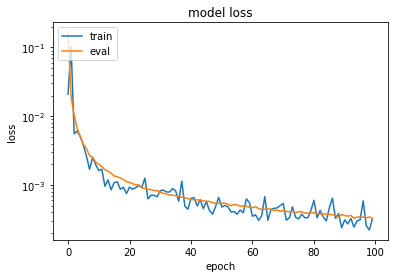

In [5]:
loss_ges = np.append(loss_ges, history.history['loss'])

if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(val_loss_ges)

plt.semilogy(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Step 2: Brigthness and Pixel Shift scattering
Here a higher number of epochs is used to reach the minimum loss function

In [6]:
Batch_Size = 8
Epoch_Anz = 400
Shift_Range = 3
Brightness_Range = 0.3

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], height_shift_range=[-Shift_Range,Shift_Range],brightness_range=[1-Brightness_Range,1+Brightness_Range])

if (Training_Percentage > 0):
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)
    history = model.fit_generator(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    history = model.fit_generator(train_iterator, epochs = Epoch_Anz)


Epoch 1/400
  1/641 [..............................] - ETA: 20s - loss: 0.6155 - accuracy: 0.7500

C:\Users\Muell\anaconda3\envs\ct-make-py38-tf24\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


641/641 [==============================] - 18s 28ms/step - loss: 0.0465 - accuracy: 0.9440 - val_loss: 0.0128 - val_accuracy: 0.9581
Epoch 2/400
641/641 [==============================] - 18s 28ms/step - loss: 0.0097 - accuracy: 0.9682 - val_loss: 0.0066 - val_accuracy: 0.9795
Epoch 3/400
641/641 [==============================] - 18s 28ms/step - loss: 0.0067 - accuracy: 0.9805 - val_loss: 0.0056 - val_accuracy: 0.9747
Epoch 4/400
641/641 [==============================] - 18s 28ms/step - loss: 0.0041 - accuracy: 0.9830 - val_loss: 0.0043 - val_accuracy: 0.9893
Epoch 5/400
641/641 [==============================] - 18s 28ms/step - loss: 0.0040 - accuracy: 0.9836 - val_loss: 0.0030 - val_accuracy: 0.9864
Epoch 6/400
641/641 [==============================] - 18s 28ms/step - loss: 0.0032 - accuracy: 0.9842 - val_loss: 0.0027 - val_accuracy: 0.9815
Epoch 7/400
641/641 [==============================] - 19s 29ms/step - loss: 0.0032 - accuracy: 0.9852 - val_loss: 0.0019 - val_accuracy: 0.98

641/641 [==============================] - 13s 20ms/step - loss: 8.0086e-04 - accuracy: 0.9943 - val_loss: 7.2567e-04 - val_accuracy: 0.9922
Epoch 57/400
641/641 [==============================] - 12s 19ms/step - loss: 8.1560e-04 - accuracy: 0.9928 - val_loss: 6.8775e-04 - val_accuracy: 0.9961
Epoch 58/400
641/641 [==============================] - 12s 19ms/step - loss: 8.0696e-04 - accuracy: 0.9940 - val_loss: 7.1178e-04 - val_accuracy: 0.9942
Epoch 59/400
641/641 [==============================] - 12s 19ms/step - loss: 7.9797e-04 - accuracy: 0.9955 - val_loss: 7.2324e-04 - val_accuracy: 0.9961
Epoch 60/400
641/641 [==============================] - 12s 19ms/step - loss: 7.9279e-04 - accuracy: 0.9924 - val_loss: 6.3600e-04 - val_accuracy: 0.9922
Epoch 61/400
641/641 [==============================] - 12s 19ms/step - loss: 8.0559e-04 - accuracy: 0.9936 - val_loss: 7.4855e-04 - val_accuracy: 0.9893
Epoch 62/400
641/641 [==============================] - 12s 19ms/step - loss: 8.1348e-04 

641/641 [==============================] - 13s 20ms/step - loss: 5.9576e-04 - accuracy: 0.9949 - val_loss: 5.4740e-04 - val_accuracy: 1.0000
Epoch 109/400
641/641 [==============================] - 13s 20ms/step - loss: 5.9964e-04 - accuracy: 0.9947 - val_loss: 5.0005e-04 - val_accuracy: 0.9961
Epoch 110/400
641/641 [==============================] - 12s 19ms/step - loss: 5.8808e-04 - accuracy: 0.9947 - val_loss: 4.1244e-04 - val_accuracy: 0.9961
Epoch 111/400
641/641 [==============================] - 12s 19ms/step - loss: 5.9810e-04 - accuracy: 0.9947 - val_loss: 5.4823e-04 - val_accuracy: 0.9922
Epoch 112/400
641/641 [==============================] - 10s 16ms/step - loss: 6.0354e-04 - accuracy: 0.9955 - val_loss: 7.2033e-04 - val_accuracy: 0.9981
Epoch 113/400
641/641 [==============================] - 9s 14ms/step - loss: 5.8401e-04 - accuracy: 0.9951 - val_loss: 6.7489e-04 - val_accuracy: 0.9971
Epoch 114/400
641/641 [==============================] - 9s 14ms/step - loss: 5.8301e

641/641 [==============================] - 8s 13ms/step - loss: 5.1530e-04 - accuracy: 0.9961 - val_loss: 3.9919e-04 - val_accuracy: 0.9971
Epoch 162/400
641/641 [==============================] - 8s 13ms/step - loss: 5.0708e-04 - accuracy: 0.9957 - val_loss: 4.9878e-04 - val_accuracy: 0.9951
Epoch 163/400
641/641 [==============================] - 8s 13ms/step - loss: 5.2652e-04 - accuracy: 0.9949 - val_loss: 4.9987e-04 - val_accuracy: 0.9932
Epoch 164/400
641/641 [==============================] - 8s 13ms/step - loss: 5.1003e-04 - accuracy: 0.9961 - val_loss: 4.2836e-04 - val_accuracy: 0.9971
Epoch 165/400
641/641 [==============================] - 8s 13ms/step - loss: 5.0626e-04 - accuracy: 0.9959 - val_loss: 5.2239e-04 - val_accuracy: 0.9942
Epoch 166/400
641/641 [==============================] - 8s 13ms/step - loss: 4.9105e-04 - accuracy: 0.9957 - val_loss: 5.4832e-04 - val_accuracy: 0.9961
Epoch 167/400
641/641 [==============================] - 8s 13ms/step - loss: 4.9476e-04 -

641/641 [==============================] - 8s 13ms/step - loss: 4.3972e-04 - accuracy: 0.9967 - val_loss: 3.9534e-04 - val_accuracy: 0.9981
Epoch 215/400
641/641 [==============================] - 8s 13ms/step - loss: 4.4797e-04 - accuracy: 0.9963 - val_loss: 4.3872e-04 - val_accuracy: 0.9981
Epoch 216/400
641/641 [==============================] - 8s 13ms/step - loss: 4.4033e-04 - accuracy: 0.9973 - val_loss: 4.6876e-04 - val_accuracy: 0.9922
Epoch 217/400
641/641 [==============================] - 8s 13ms/step - loss: 4.3824e-04 - accuracy: 0.9967 - val_loss: 3.5176e-04 - val_accuracy: 0.9981
Epoch 218/400
641/641 [==============================] - 8s 13ms/step - loss: 4.2665e-04 - accuracy: 0.9961 - val_loss: 4.5459e-04 - val_accuracy: 0.9951
Epoch 219/400
641/641 [==============================] - 8s 13ms/step - loss: 4.2213e-04 - accuracy: 0.9961 - val_loss: 3.8765e-04 - val_accuracy: 0.9971
Epoch 220/400
641/641 [==============================] - 8s 12ms/step - loss: 4.4648e-04 -

641/641 [==============================] - 8s 13ms/step - loss: 3.9781e-04 - accuracy: 0.9957 - val_loss: 3.6731e-04 - val_accuracy: 0.9961
Epoch 268/400
641/641 [==============================] - 8s 13ms/step - loss: 4.1088e-04 - accuracy: 0.9967 - val_loss: 3.8433e-04 - val_accuracy: 0.9990
Epoch 269/400
641/641 [==============================] - 8s 13ms/step - loss: 4.0468e-04 - accuracy: 0.9961 - val_loss: 4.2182e-04 - val_accuracy: 0.9922
Epoch 270/400
641/641 [==============================] - 8s 13ms/step - loss: 4.0019e-04 - accuracy: 0.9967 - val_loss: 3.5402e-04 - val_accuracy: 0.9942
Epoch 271/400
641/641 [==============================] - 8s 13ms/step - loss: 3.9193e-04 - accuracy: 0.9959 - val_loss: 3.5072e-04 - val_accuracy: 0.9951
Epoch 272/400
641/641 [==============================] - 8s 13ms/step - loss: 3.7495e-04 - accuracy: 0.9967 - val_loss: 4.7345e-04 - val_accuracy: 0.9981
Epoch 273/400
641/641 [==============================] - 8s 13ms/step - loss: 3.8872e-04 -

641/641 [==============================] - 8s 13ms/step - loss: 3.8590e-04 - accuracy: 0.9961 - val_loss: 3.3023e-04 - val_accuracy: 0.9981
Epoch 321/400
641/641 [==============================] - 8s 13ms/step - loss: 3.8179e-04 - accuracy: 0.9969 - val_loss: 3.4656e-04 - val_accuracy: 0.9981
Epoch 322/400
641/641 [==============================] - 8s 13ms/step - loss: 3.5872e-04 - accuracy: 0.9959 - val_loss: 3.9222e-04 - val_accuracy: 0.9951
Epoch 323/400
641/641 [==============================] - 8s 13ms/step - loss: 3.7189e-04 - accuracy: 0.9975 - val_loss: 3.1600e-04 - val_accuracy: 0.9990
Epoch 324/400
641/641 [==============================] - 8s 13ms/step - loss: 3.8461e-04 - accuracy: 0.9975 - val_loss: 3.2381e-04 - val_accuracy: 0.9942
Epoch 325/400
641/641 [==============================] - 8s 13ms/step - loss: 3.8382e-04 - accuracy: 0.9975 - val_loss: 3.5986e-04 - val_accuracy: 0.9961
Epoch 326/400
641/641 [==============================] - 8s 13ms/step - loss: 3.6176e-04 -

641/641 [==============================] - 8s 13ms/step - loss: 3.4032e-04 - accuracy: 0.9961 - val_loss: 3.0634e-04 - val_accuracy: 0.9971
Epoch 374/400
641/641 [==============================] - 8s 13ms/step - loss: 3.5043e-04 - accuracy: 0.9973 - val_loss: 3.4762e-04 - val_accuracy: 0.9951
Epoch 375/400
641/641 [==============================] - 8s 13ms/step - loss: 3.4275e-04 - accuracy: 0.9973 - val_loss: 2.6295e-04 - val_accuracy: 0.9990
Epoch 376/400
641/641 [==============================] - 8s 13ms/step - loss: 3.4726e-04 - accuracy: 0.9963 - val_loss: 3.4043e-04 - val_accuracy: 0.9942
Epoch 377/400
641/641 [==============================] - 8s 13ms/step - loss: 3.5749e-04 - accuracy: 0.9963 - val_loss: 3.4020e-04 - val_accuracy: 0.9990
Epoch 378/400
641/641 [==============================] - 8s 13ms/step - loss: 3.3311e-04 - accuracy: 0.9965 - val_loss: 3.7249e-04 - val_accuracy: 0.9961
Epoch 379/400
641/641 [==============================] - 8s 13ms/step - loss: 3.4361e-04 -

### Overall Learing results (Step 1 & Step 2)

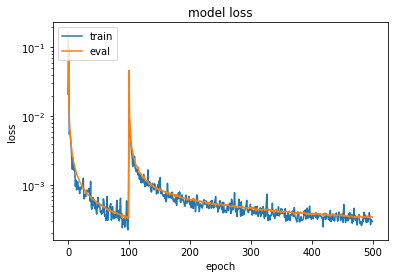

In [7]:
loss_ges = np.append(loss_ges, history.history['loss'])


if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(val_loss_ges)


plt.semilogy(loss_ges)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Check the model by hand

* The following code uses the trained model to check the deviation for each picture.
* The evaluation takes the periodic character of the results into account (dev1 ... dev2).
* Images, that have a bigger deviation as the parameter "deviation_max_list" are printed in a list to check the picture and labeling itself

In [8]:
Input_dir='data_resize_all'
#Input_dir='test_result'
files = glob.glob(Input_dir + '/*.*')
res = []
stat_Anz = []
stat_Abweichung = []
i = 0
deviation_max_list = 0.05

for i in range(100):
    stat_Anz.append(0)
    stat_Abweichung.append(0)

for aktfile in files:
    base = os.path.basename(aktfile)
    target = (float(base[0:3])) / 10
    
    target_sin = math.sin(target * math.pi * 2)
    target_cos = math.cos(target * math.pi * 2)

    test_image = Image.open(aktfile)
    test_image = np.array(test_image, dtype="float32")
    img = np.reshape(test_image,[1,32,32,3])
    classes = model.predict(img)
    
    out_sin = classes[0][0]  
    out_cos = classes[0][1]
    out_target = (np.arctan2(out_sin, out_cos)/(2*math.pi)) % 1

    dev_sin = target_sin - out_sin
    dev_cos = target_cos - out_cos
    dev_target = target - out_target
    
    if abs(dev_target + 1) < abs(dev_target):
        out_target = out_target - 1
        dev_target = target - out_target
    else:
        if abs(dev_target - 1) < abs(dev_target):
            out_target = out_target + 1
            dev_target = target - out_target
            
    target_int = int ((float(base[0:3])) * 10)
    stat_Abweichung[target_int] = stat_Abweichung[target_int] + dev_target  
    stat_Anz[target_int] = stat_Anz[target_int] + 1
               
    res.append(np.array([target, out_target, dev_target, out_sin, out_cos, i]))
    if abs(dev_target) > deviation_max_list:
        print(aktfile + " " + str(target) + " " + str(out_target) +  " " + str(dev_target))

    
for i in range(100):
    stat_Abweichung[i] = stat_Abweichung[i] / stat_Anz[i]

res = np.asarray(res)
res_step_1 = res

data_resize_all\0.0_0006_zeiger1_2020-04-29_10-56-43.jpg 0.0 -0.05081101046432501 0.05081101046432501
data_resize_all\0.7_0251_zeiger2_2020-04-29_13-43-02.jpg 0.06999999999999999 0.016917817692267866 0.05308218230773212
data_resize_all\3.3_1693_zeiger3_2020-04-29_13-46-02.jpg 0.32999999999999996 0.38086906866625764 -0.05086906866625768
data_resize_all\6.5_3274_zeiger3_2019-11-19_02-22-03.jpg 0.65 0.7026665923674509 -0.05266659236745086
data_resize_all\8.3_4117_zeiger1_2020-04-29_14-43-02.jpg 0.8300000000000001 0.7745303138832539 0.055469686116746186
data_resize_all\8.3_4145_zeiger1_2020-04-29_12-04-02.jpg 0.8300000000000001 0.7798074698179873 0.05019253018201275
data_resize_all\8.5_4215_zeiger1_2020-04-29_14-44-02.jpg 0.85 0.7703705579239869 0.07962944207601308
data_resize_all\8.8_4323_zeiger1_2020-04-29_13-25-02.jpg 0.8800000000000001 0.8216167842476756 0.058383215752324524
data_resize_all\9.0_4439_zeiger1_2020-04-29_13-27-02.jpg 0.9 0.8496479659787725 0.050352034021227565
data_resize

## Results

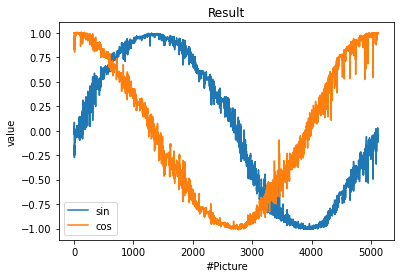

In [9]:
plt.plot(res[:,3])
plt.plot(res[:,4])
plt.title('Result')
plt.ylabel('value')
plt.xlabel('#Picture')
plt.legend(['sin', 'cos'], loc='lower left')
plt.show()

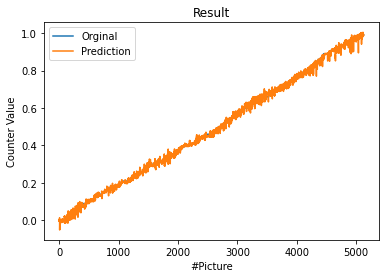

In [10]:
plt.plot(res[:,0])
plt.plot(res[:,1])
plt.title('Result')
plt.ylabel('Counter Value')
plt.xlabel('#Picture')
plt.legend(['Orginal', 'Prediction'], loc='upper left')
plt.show()

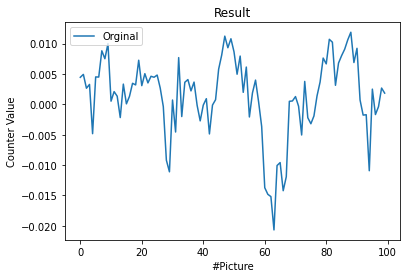

In [11]:
plt.plot(stat_Abweichung)
plt.title('Result')
plt.ylabel('Counter Value')
plt.xlabel('#Picture')
plt.legend(['Orginal', 'Prediction'], loc='upper left')
plt.show()

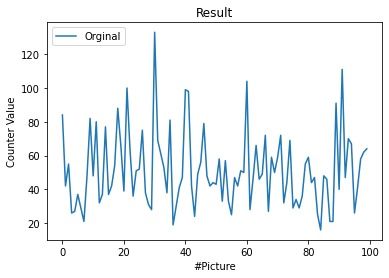

In [12]:
plt.plot(stat_Anz)
plt.title('Result')
plt.ylabel('Counter Value')
plt.xlabel('#Picture')
plt.legend(['Orginal', 'Prediction'], loc='upper left')
plt.show()

### Deviation from Expected Value

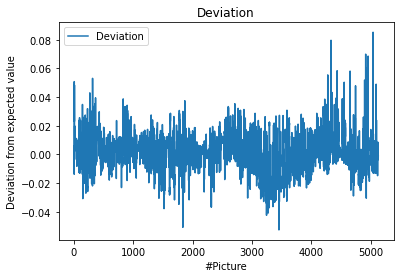

[ 0.0013  0.0121 -0.0527  0.0852]


In [13]:
plt.plot(res[:,2])
plt.title('Deviation')
plt.ylabel('Deviation from expected value')
plt.xlabel('#Picture')
plt.legend(['Deviation'], loc='upper left')
#plt.ylim(-0.3, 0.3)
plt.show()

statistic = np.array([np.mean(res[:,2]), np.std(res[:,2]), np.min(res[:,2]), np.max(res[:,2])])
print(statistic)

### Save the model

* Save the model to the file with the "h5" file format

In [26]:
FileName = TFliteNamingAndVersion

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(FileName + ".tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpoget7no_\assets


INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpoget7no_\assets


204360

In [27]:
from pathlib import Path
import tensorflow as tf

FileName = TFliteNamingAndVersion + "q" + ".tflite"

def representative_dataset():
    for n in range(x_data[0].size):
      data = np.expand_dims(x_data[5], axis=0)
      yield [data.astype(np.float32)]
        
converter2 = tf.lite.TFLiteConverter.from_keras_model(model)
converter2.representative_dataset = representative_dataset
converter2.optimizations = [tf.lite.Optimize.DEFAULT]
converter2.representative_dataset = representative_dataset
tflite_quant_model = converter2.convert()

open(FileName, "wb").write(tflite_quant_model)
print(FileName)
Path(FileName).stat().st_size

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpwms66as6\assets


INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpwms66as6\assets


ana0900s1_longq.tflite


60464